In [1]:
import json
import pandas as pd
import ast
import numpy as np

def load_data_from_json(file_name):
    file_data = open(file_name)
    
    list_data = []
    while 1:
        line = file_data.readline()
        if not line:
            break
        sample_dict = ast.literal_eval(str(line).replace('\n', ''))
        list_data.append(sample_dict)
    df = pd.DataFrame(list_data)
    return df


df_train = load_data_from_json('../data/train.json')
x_train,y_train = df_train['sentence'],df_train['label']


df_dev = load_data_from_json('../data/dev.json')
x_dev,y_dev = df_dev['sentence'],df_dev['label']


df_test = load_data_from_json('../data/test.json')
x_test,y_test = df_test['sentence'],df_test['label']

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.externals import joblib



vectorizer_word = TfidfVectorizer(max_features=40000,
                                  min_df=5,
                                  max_df=0.5,
                                  analyzer='word',
                                  stop_words='english',
                                  ngram_range=(1, 2))

vectorizer_word.fit(x_train)

tfidf_matrix_word_train = vectorizer_word.transform(x_train)
tfidf_matrix_word_dev = vectorizer_word.transform(x_dev)
tfidf_matrix_word_test = vectorizer_word.transform(x_test)

In [3]:
lr_word = LogisticRegression(solver='sag', verbose=2)
lr_word.fit(tfidf_matrix_word_train, y_train)

convergence after 21 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=2, warm_start=False)

In [4]:
y_pred_word_dev = lr_word.predict(tfidf_matrix_word_dev)
print(accuracy_score(y_dev, y_pred_word_dev))

y_pred_word_test = lr_word.predict(tfidf_matrix_word_test)
print(accuracy_score(y_test, y_pred_word_test))

0.7385416666666667
0.7401500938086304


In [5]:
from tqdm import tqdm,tqdm_notebook
vectorizer_char = TfidfVectorizer(max_features=40000,
                                  min_df=5,
                                  max_df=0.5,
                                  analyzer='char',
                                  ngram_range=(1, 4))

vectorizer_char.fit(tqdm_notebook(x_train));

tfidf_matrix_char_train = vectorizer_char.transform(x_train)
tfidf_matrix_char_dev = vectorizer_char.transform(x_dev)
tfidf_matrix_char_test = vectorizer_char.transform(x_test)


lr_char = LogisticRegression(solver='sag', verbose=2)
lr_char.fit(tfidf_matrix_char_train, y_train)

y_pred_char_dev = lr_char.predict(tfidf_matrix_char_dev)
print(accuracy_score(y_dev, y_pred_char_dev))

y_pred_char_test = lr_char.predict(tfidf_matrix_char_test)
print(accuracy_score(y_test, y_pred_char_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
0.7552083333333334
0.7570356472795498


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [6]:
import scipy
from scipy.sparse import hstack

tfidf_matrix_word_char_train = hstack((tfidf_matrix_word_train, tfidf_matrix_char_train))
tfidf_matrix_word_char_dev = hstack((tfidf_matrix_word_dev, tfidf_matrix_char_dev))
tfidf_matrix_word_char_test = hstack((tfidf_matrix_word_test, tfidf_matrix_char_test))


lr_word_char = LogisticRegression(solver='sag', verbose=2)
lr_word_char.fit(tfidf_matrix_word_char_train, y_train)

y_pred_word_char_dev = lr_word_char.predict(tfidf_matrix_word_char_dev)
print(accuracy_score(y_dev, y_pred_word_char_dev))


y_pred_word_char_test = lr_word_char.predict(tfidf_matrix_word_char_test)
print(accuracy_score(y_test, y_pred_word_char_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 1 seconds
0.7625
0.775797373358349


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model


MAX_NB_WORDS = 40000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(list(x_train)+list(x_dev))

Using TensorFlow backend.


In [8]:
data_all = list(x_train)+list(x_dev)
data_all_lens = [len(str(data_i).split()) for data_i in data_all  ]

/Users/blair/.pyenv/versions/aic/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


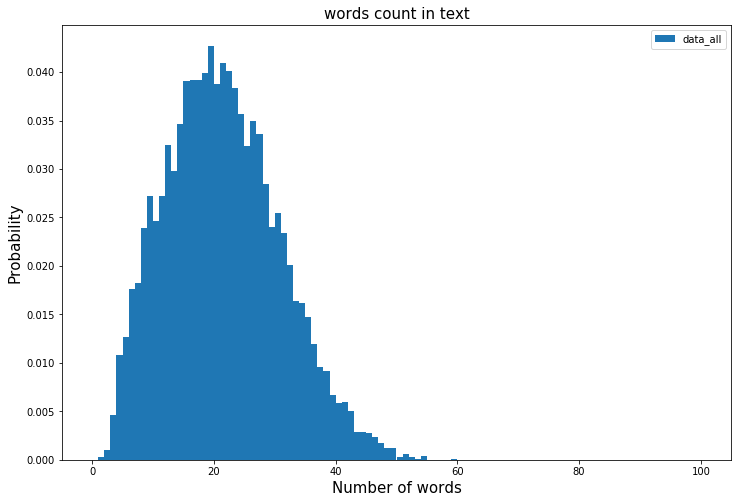

In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.hist(data_all_lens, bins=100, range=[0, 100], normed=True, label='data_all')
plt.title('words count in text', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()


In [12]:
train_sequences = tokenizer.texts_to_sequences(x_train)
dev_sequences = tokenizer.texts_to_sequences(x_dev)
test_sequences = tokenizer.texts_to_sequences(x_test)


MAX_LENGTH = 50
padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
padded_dev_sequences = pad_sequences(dev_sequences, maxlen=MAX_LENGTH)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

In [13]:
padded_train_sequences.shape

(8636, 50)

In [14]:
def get_simple_rnn_model():
    embedding_dim = 300
    embedding_matrix = np.random.random((MAX_NB_WORDS, embedding_dim))

    inp = Input(shape=(MAX_LENGTH,))
    
    x = Embedding(input_dim=MAX_NB_WORDS, output_dim=embedding_dim, input_length=MAX_LENGTH,
                  weights=[embedding_matrix], trainable=True)(inp)
    
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


rnn_simple_model = get_simple_rnn_model()

In [16]:
filepath = "../model/non_embedding-weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
 mode='max')

batch_size = 256
epochs = 10

history = rnn_simple_model.fit(x=padded_train_sequences,
                               y=y_train,
                               validation_data=(padded_dev_sequences, y_dev),
                               batch_size=batch_size,
                               callbacks=[checkpoint],
                               epochs=epochs,
                               verbose=1)

Train on 8636 samples, validate on 960 samples
Epoch 1/10
8636/8636 [==============================] - 27s 3ms/step - loss: 0.7044 - acc: 0.5139 - val_loss: 0.6811 - val_acc: 0.5615

Epoch 00001: val_acc improved from -inf to 0.56146, saving model to ../model/non_embedding-weights-improvement-01-0.5615.hdf5
Epoch 2/10
8636/8636 [==============================] - 27s 3ms/step - loss: 0.6793 - acc: 0.5672 - val_loss: 0.6706 - val_acc: 0.5604

Epoch 00002: val_acc did not improve from 0.56146
Epoch 3/10
8636/8636 [==============================] - 29s 3ms/step - loss: 0.6576 - acc: 0.6106 - val_loss: 0.6368 - val_acc: 0.6646

Epoch 00003: val_acc improved from 0.56146 to 0.66458, saving model to ../model/non_embedding-weights-improvement-03-0.6646.hdf5
Epoch 4/10
8636/8636 [==============================] - 29s 3ms/step - loss: 0.6220 - acc: 0.6759 - val_loss: 0.6096 - val_acc: 0.6750

Epoch 00004: val_acc improved from 0.66458 to 0.67500, saving model to ../model/non_embedding-weights-im

## 导入rnn_simple_model中最好的一个，进行预测

In [19]:
best_rnn_simple_model = load_model('../model/non_embedding-weights-improvement-07-0.7354.hdf5')

y_pred_rnn_simple = best_rnn_simple_model.predict(padded_test_sequences, verbose=1, batch_size=128)

y_pred_rnn_simple = pd.DataFrame(y_pred_rnn_simple, columns=['prediction'])

y_pred_rnn_simple['prediction'] = y_pred_rnn_simple['prediction'].map(lambda p: 1 if p >= 0.5 else 0)

y_pred_rnn_simple.to_csv('../model/y_pred_rnn_simple.csv', index=False)

y_pred_rnn_simple = pd.read_csv('../model/y_pred_rnn_simple.csv')

accuracy_score(y_test, y_pred_rnn_simple)

1066/1066 [==============================] - 1s 1ms/step


0.7204502814258912

## 5. glove rnn model

In [23]:

def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None


embeddings_index = dict(get_coefs(*o.strip().split()) for o in tqdm_notebook(
        open('../data/glove.840B.300d.txt')))

embed_size = 300

for k in tqdm_notebook(list(embeddings_index.keys())):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size,):
            embeddings_index.pop(k)
    except:
        pass

In [24]:
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()
word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

oov = 0
for word, i in tqdm_notebook(word_index.items()):
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1

print(oov)


def get_rnn_model_with_glove_embeddings():
    
    embedding_dim = 300
    
    inp = Input(shape=(MAX_LENGTH,))
    
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], 
input_length=MAX_LENGTH, trainable=True)(inp)
    
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=inp, outputs=outp)
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


rnn_model_with_embeddings = get_rnn_model_with_glove_embeddings()


2435


In [28]:
filepath = "../model/rnn_glove_embedding-weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 256
epochs = 5

history = rnn_model_with_embeddings.fit(x=padded_train_sequences,
                            y=y_train,
                            validation_data=(padded_dev_sequences, y_dev),
                            batch_size=batch_size,
                                        callbacks=[checkpoint],
                                        epochs=epochs,
                                        verbose=1)

Train on 8636 samples, validate on 960 samples
Epoch 1/5
8636/8636 [==============================] - 31s 4ms/step - loss: 0.0229 - acc: 0.9922 - val_loss: 1.0539 - val_acc: 0.7563

Epoch 00001: val_acc improved from -inf to 0.75625, saving model to ../model/rnn_glove_embedding-weights-improvement-01-0.7563.hdf5
Epoch 2/5
8636/8636 [==============================] - 30s 4ms/step - loss: 0.0201 - acc: 0.9939 - val_loss: 1.1487 - val_acc: 0.7531

Epoch 00002: val_acc did not improve from 0.75625
Epoch 3/5
8636/8636 [==============================] - 33s 4ms/step - loss: 0.0184 - acc: 0.9943 - val_loss: 1.2128 - val_acc: 0.7521

Epoch 00003: val_acc did not improve from 0.75625
Epoch 4/5
8636/8636 [==============================] - 33s 4ms/step - loss: 0.0183 - acc: 0.9934 - val_loss: 1.1407 - val_acc: 0.7594

Epoch 00004: val_acc improved from 0.75625 to 0.75938, saving model to ../model/rnn_glove_embedding-weights-improvement-04-0.7594.hdf5
Epoch 5/5
8636/8636 [=========================

###  导入 glove rnn model 中最好的一个，进行预测

In [29]:
best_rnn_model_with_glove_embeddings = load_model('../model/rnn_glove_embedding-weights-improvement-01-0.7906.hdf5')

y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(
    padded_test_sequences, verbose=1, batch_size=128)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings, columns=['prediction'])

y_pred_rnn_with_glove_embeddings['prediction'] = y_pred_rnn_with_glove_embeddings['prediction'].map(lambda p:1 if p >= 0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('../model/y_pred_rnn_with_glove_embeddings.csv', index=False)

y_pred_rnn_with_glove_embeddings = pd.read_csv('../model/y_pred_rnn_with_glove_embeddings.csv')

accuracy_score(y_test, y_pred_rnn_with_glove_embeddings)

1066/1066 [==============================] - 1s 1ms/step


0.799249530956848

## 6. cnn model

In [31]:
def get_cnn_model():
    embedding_dim = 300

    filter_sizes = [2, 3, 5]
    num_filters = 256
    drop = 0.3

    inputs = Input(shape=(MAX_LENGTH,), dtype='int32')
    
    embedding = Embedding(input_dim=MAX_NB_WORDS,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=MAX_LENGTH,
                          trainable=True)(inputs)

    reshape = Reshape((MAX_LENGTH, embedding_dim, 1))(embedding)
    
    conv_0 = Conv2D(num_filters,
                    kernel_size=(filter_sizes[0], embedding_dim),
                    padding='valid', kernel_initializer='normal',
                    activation='relu')(reshape)

    conv_1 = Conv2D(num_filters,
                    kernel_size=(filter_sizes[1], embedding_dim),
                    padding='valid', kernel_initializer='normal',
                    activation='relu')(reshape)
    conv_2 = Conv2D(num_filters,
                    kernel_size=(filter_sizes[2], embedding_dim),
                    padding='valid', kernel_initializer='normal',
                    activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1),
                          strides=(1, 1), padding='valid')(conv_0)

    maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1),
                          strides=(1, 1), padding='valid')(conv_1)

    maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1),
                          strides=(1, 1), padding='valid')(conv_2)
    concatenated_tensor = Concatenate(axis=1)(
        [maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=1, activation='sigmoid')(dropout)

    model = Model(inputs=inputs, outputs=output)
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model


cnn_model_multi_channel = get_cnn_model()

In [33]:
filepath = "../model/cnn-weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 256
epochs = 10

history = cnn_model_multi_channel.fit(x=padded_train_sequences,
                                      y=y_train,
                            validation_data=(padded_dev_sequences, y_dev),
                                      batch_size=batch_size,
                                      callbacks=[checkpoint],
                                      epochs=epochs,
                                      verbose=1)

Train on 8636 samples, validate on 960 samples
Epoch 1/10
8636/8636 [==============================] - 37s 4ms/step - loss: 0.5116 - acc: 0.7455 - val_loss: 0.4973 - val_acc: 0.7458

Epoch 00001: val_acc improved from -inf to 0.74583, saving model to ../model/cnn-weights-improvement-01-0.7458.hdf5
Epoch 2/10
8636/8636 [==============================] - 39s 4ms/step - loss: 0.4835 - acc: 0.7637 - val_loss: 0.4863 - val_acc: 0.7531

Epoch 00002: val_acc improved from 0.74583 to 0.75313, saving model to ../model/cnn-weights-improvement-02-0.7531.hdf5
Epoch 3/10
8636/8636 [==============================] - 37s 4ms/step - loss: 0.4513 - acc: 0.7890 - val_loss: 0.4786 - val_acc: 0.7490

Epoch 00003: val_acc did not improve from 0.75313
Epoch 4/10
8636/8636 [==============================] - 38s 4ms/step - loss: 0.4292 - acc: 0.8051 - val_loss: 0.4717 - val_acc: 0.7521

Epoch 00004: val_acc did not improve from 0.75313
Epoch 5/10
8636/8636 [==============================] - 38s 4ms/step - los

### 导入 cnn_model 中最好的一个，进行预测

In [38]:
best_cnn_model = load_model('../model/cnn-weights-improvement-09-0.7740.hdf5')

y_pred_cnn_multi_channel = best_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=128)

y_pred_cnn_multi_channel = pd.DataFrame(y_pred_cnn_multi_channel, columns=['prediction'])
y_pred_cnn_multi_channel['prediction'] = y_pred_cnn_multi_channel['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_cnn_multi_channel.to_csv('../model/y_pred_cnn_multi_channel.csv', index=False)

y_pred_cnn_multi_channel = pd.read_csv('../model/y_pred_cnn_multi_channel.csv')
accuracy_score(y_test, y_pred_cnn_multi_channel)

1066/1066 [==============================] - 1s 1ms/step


0.776735459662289

## 7. RCNN

In [57]:
def get_rnn_cnn_model():
    
    embedding_dim = 300
    
    inp = Input(shape=(MAX_LENGTH,))
    
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], 
input_length=MAX_LENGTH, trainable=True)(inp)
    
    x = SpatialDropout1D(0.3)(x)
    
    x = Bidirectional(GRU(100, return_sequences=True))(x)
    
    x = Conv1D(64, kernel_size=2, padding="valid", kernel_initializer="he_uniform")(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


rnn_cnn_model = get_rnn_cnn_model()

In [58]:
filepath = "../model/rcnn-weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
save_best_only=True, mode='max')

batch_size = 256
epochs = 6

history = rnn_cnn_model.fit(x=padded_train_sequences,
                            y=y_train,
                            validation_data=(padded_dev_sequences, y_dev),
                            batch_size=batch_size,
                            callbacks=[checkpoint],
                            epochs=epochs,
                            verbose=1)

Train on 8636 samples, validate on 960 samples
Epoch 1/6
8636/8636 [==============================] - 27s 3ms/step - loss: 0.6293 - acc: 0.6467 - val_loss: 0.5179 - val_acc: 0.7490

Epoch 00001: val_acc improved from -inf to 0.74896, saving model to ../model/rcnn-drop0.2-weights-improvement-01-0.7490.hdf5
Epoch 2/6
8636/8636 [==============================] - 24s 3ms/step - loss: 0.4662 - acc: 0.7808 - val_loss: 0.4667 - val_acc: 0.7844

Epoch 00002: val_acc improved from 0.74896 to 0.78438, saving model to ../model/rcnn-drop0.2-weights-improvement-02-0.7844.hdf5
Epoch 3/6
8636/8636 [==============================] - 24s 3ms/step - loss: 0.3705 - acc: 0.8370 - val_loss: 0.4452 - val_acc: 0.7990

Epoch 00003: val_acc improved from 0.78438 to 0.79896, saving model to ../model/rcnn-drop0.2-weights-improvement-03-0.7990.hdf5
Epoch 4/6
8636/8636 [==============================] - 23s 3ms/step - loss: 0.2956 - acc: 0.8715 - val_loss: 0.4754 - val_acc: 0.7865

Epoch 00004: val_acc did not imp

###  导入 rnn_cnn_model 中最好的一个，进行预测

### test , padded_test_sequences

In [49]:
best_rnn_cnn_model = load_model('../model/rcnn-weights-improvement-04-0.8167.hdf5')
y_pred_rnn_cnn = best_rnn_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=128)

y_pred_rnn_cnn = pd.DataFrame(y_pred_rnn_cnn, columns=['prediction'])
y_pred_rnn_cnn['prediction'] = y_pred_rnn_cnn['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_rnn_cnn.to_csv('../model/y_pred_rnn_cnn.csv', index=False)

y_pred_rnn_cnn = pd.read_csv('../model/y_pred_rnn_cnn.csv')
accuracy_score(y_test, y_pred_rnn_cnn)

1066/1066 [==============================] - 2s 2ms/step


0.8123827392120075